<a href="https://colab.research.google.com/github/kridtapon/VolGuard-PF/blob/main/VolGuard_PF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.6/527.6 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.8 MB/s eta 0:00:00


In [ ]:
pip install --upgrade yfinance

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt

# ---------------------------
# PART 1: STOCHASTIC VOLATILITY ESTIMATION VIA PARTICLE FILTER
# ---------------------------

def particle_filter_volatility(df, num_particles=500):
    """
    Estimate latent volatility using a simple stochastic volatility model
    and bootstrap particle filtering.

    Model details:
    - State equation for log volatility, h_t:
         h_t = mu + phi*(h_{t-1} - mu) + sigma_eta * noise,
      with parameters (mu, phi, sigma_eta) chosen heuristically.
    - Observation equation using the log return defined as:
         r_t = log(Close / Open)
      with likelihood: r_t ~ N(0, exp(h_t)).

    Returns a Pandas Series of volatility estimates for each time step.
    """
    # Set model parameters (these may be calibrated on historical data)
    mu = np.log(0.1)    # long-run mean of log volatility
    phi = 0.98          # persistence of volatility
    sigma_eta = 0.2     # volatility of volatility

    T = len(df)
    # Initialize particles for log volatility (h_t)
    particles = np.ones(num_particles) * mu
    # Uniform initial weights
    weights = np.ones(num_particles) / num_particles
    volatility_est = np.zeros(T)

    # Define observations as log returns
    returns = np.log(df['Close'] / df['Open']).values

    for t in range(T):
        # 1. Propagate: update each particle according to the state model
        particles = mu + phi * (particles - mu) + sigma_eta * np.random.randn(num_particles)

        # 2. Measurement update:
        #     Assume: r_t ~ Normal(0, exp(h_t)) where exp(h_t) is the variance
        obs_variance = np.exp(particles)
        likelihoods = (1/np.sqrt(2 * np.pi * obs_variance)) * np.exp(- (returns[t]**2) / (2 * obs_variance))

        # Multiply previous weights by likelihoods
        weights *= likelihoods
        weights_sum = np.sum(weights)
        if weights_sum == 0:
            # Reset if all particles vanish
            weights = np.ones(num_particles) / num_particles
        else:
            weights /= weights_sum

        # 3. Estimate volatility at time t: using the weighted average of particles
        vol_est = np.exp(np.average(particles, weights=weights))
        volatility_est[t] = vol_est

        # 4. Resample if effective sample size is too low
        effective_N = 1 / np.sum(weights**2)
        if effective_N < num_particles / 2:
            indices = np.random.choice(np.arange(num_particles), size=num_particles, p=weights)
            particles = particles[indices]
            weights = np.ones(num_particles) / num_particles

    return pd.Series(volatility_est, index=df.index)

# ---------------------------
# PART 2: DATA DOWNLOAD AND CALCULATIONS
# ---------------------------

# Define the stock symbol and time period (using META as example)
symbol = 'META'
start_date = '2019-01-01'
end_date = '2025-01-01'

# Download historical data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# Apply the particle filter to estimate latent volatility based on OHLC data
df['Est_Vol'] = particle_filter_volatility(df, num_particles=500)

# ---------------------------
# PART 3: STRATEGY SIGNAL GENERATION USING VOLATILITY FILTER
# ---------------------------
# For example, you might only take entry positions when the volatility estimate is lower than its 30-day moving average.
vol_rolling = df['Est_Vol'].rolling(window=30).mean()

# Modify the trading signals:
# - Entry: when the estimated volatility is below its 30-day average.
# - Exit: when the volatility estimate rises above its 30-day average.
df['Entry'] = (df['Est_Vol'] < vol_rolling)

df['Exit'] = (df['Est_Vol'] >= vol_rolling)

# Filter the data for the test period (2020-2025)
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# ---------------------------
# PART 4: BACKTEST THE STRATEGY USING VECTORBT
# ---------------------------
portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=df['Entry'],
    exits=df['Exit'],
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='D'
)

# Display performance metrics
print(portfolio.stats())

# Plot equity curve
portfolio.plot().show()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Start                                2020-01-02 00:00:00
End                                  2024-12-31 00:00:00
Period                                1258 days 00:00:00
Start Value                                     100000.0
End Value                                  530374.452743
Total Return [%]                              430.374453
Benchmark Return [%]                          180.172878
Max Gross Exposure [%]                             100.0
Total Fees Paid                             21476.853756
Max Drawdown [%]                               27.417993
Max Drawdown Duration                  528 days 00:00:00
Total Trades                                          55
Total Closed Trades                                   54
Total Open Trades                                      1
Open Trade PnL                              -1592.184107
Win Rate [%]                                   57.407407
Best Trade [%]                                  61.61191
Worst Trade [%]                

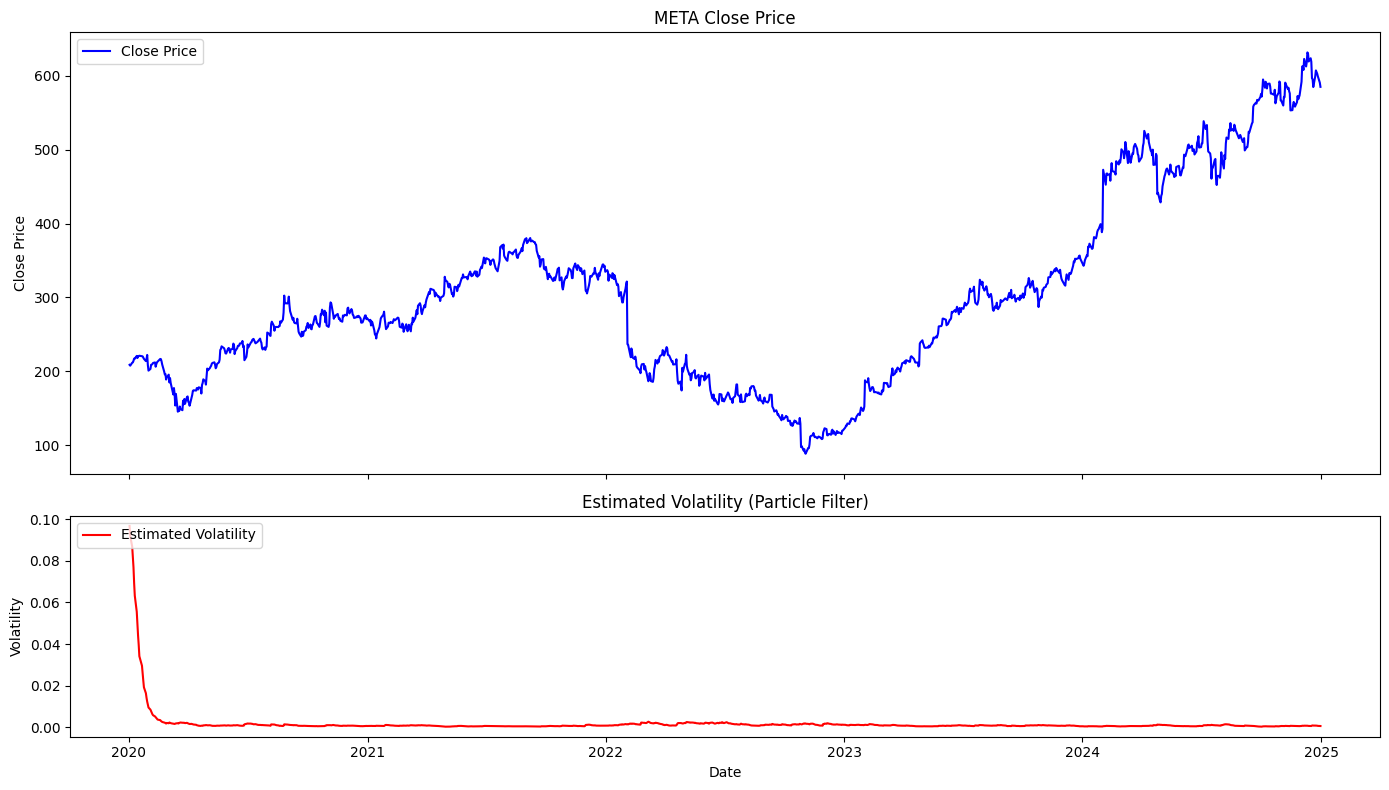

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# Run the particle filter to estimate volatility
volatility_series = particle_filter_volatility(df)

# Plotting with separate panels
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# Panel 1: Closing price
ax1.plot(df.index, df['Close'], color='blue', label='Close Price')
ax1.set_ylabel('Close Price')
ax1.legend(loc='upper left')
ax1.set_title(f'{symbol} Close Price')

# Panel 2: Volatility estimate
ax2.plot(volatility_series.index, volatility_series, color='red', label='Estimated Volatility')
ax2.set_xlabel('Date')
ax2.set_ylabel('Volatility')
ax2.legend(loc='upper left')
ax2.set_title('Estimated Volatility (Particle Filter)')

plt.tight_layout()
plt.show()


No randomness

No resampling or weights

Fully repeatable output every run

Still usable with the rest of your strategy logic

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt

# ---------------------------
# PART 1: DETERMINISTIC VOLATILITY ESTIMATOR
# ---------------------------

def deterministic_volatility(df, window=30):
    """
    Deterministic volatility estimator using rolling standard deviation
    of log returns over a specified window.
    """
    log_returns = np.log(df['Close'] / df['Open'])
    return log_returns.rolling(window=window).std()

# ---------------------------
# PART 2: DATA DOWNLOAD AND CALCULATIONS
# ---------------------------

# Define the stock symbol and time period
symbol = 'META'
start_date = '2019-01-01'
end_date = '2025-01-01'

# Download historical data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# Calculate deterministic volatility
df['Est_Vol'] = deterministic_volatility(df, window=30)

# ---------------------------
# PART 3: STRATEGY SIGNAL GENERATION USING VOLATILITY FILTER
# ---------------------------

# 30-day moving average of volatility
vol_rolling = df['Est_Vol'].rolling(window=30).mean()

# Entry signal: when volatility is below its 30-day average
df['Entry'] = (df['Est_Vol'] < vol_rolling)

# Exit signal: when volatility rises above its 30-day average
df['Exit'] = (df['Est_Vol'] >= vol_rolling)

# Filter the data for the test period (2020-2025)
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# ---------------------------
# PART 4: BACKTEST THE STRATEGY USING VECTORBT
# ---------------------------

portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=df['Entry'],
    exits=df['Exit'],
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='D'
)

# Display performance metrics
print(portfolio.stats())

# Plot equity curve
portfolio.plot().show()


[*********************100%***********************]  1 of 1 completed


Start                                2020-01-02 00:00:00
End                                  2024-12-31 00:00:00
Period                                1258 days 00:00:00
Start Value                                     100000.0
End Value                                  326205.972576
Total Return [%]                              226.205973
Benchmark Return [%]                          180.172878
Max Gross Exposure [%]                             100.0
Total Fees Paid                             11859.859433
Max Drawdown [%]                               38.132984
Max Drawdown Duration                  353 days 00:00:00
Total Trades                                          40
Total Closed Trades                                   40
Total Open Trades                                      0
Open Trade PnL                                       0.0
Win Rate [%]                                        57.5
Best Trade [%]                                 47.242916
Worst Trade [%]                

[*********************100%***********************]  1 of 1 completed


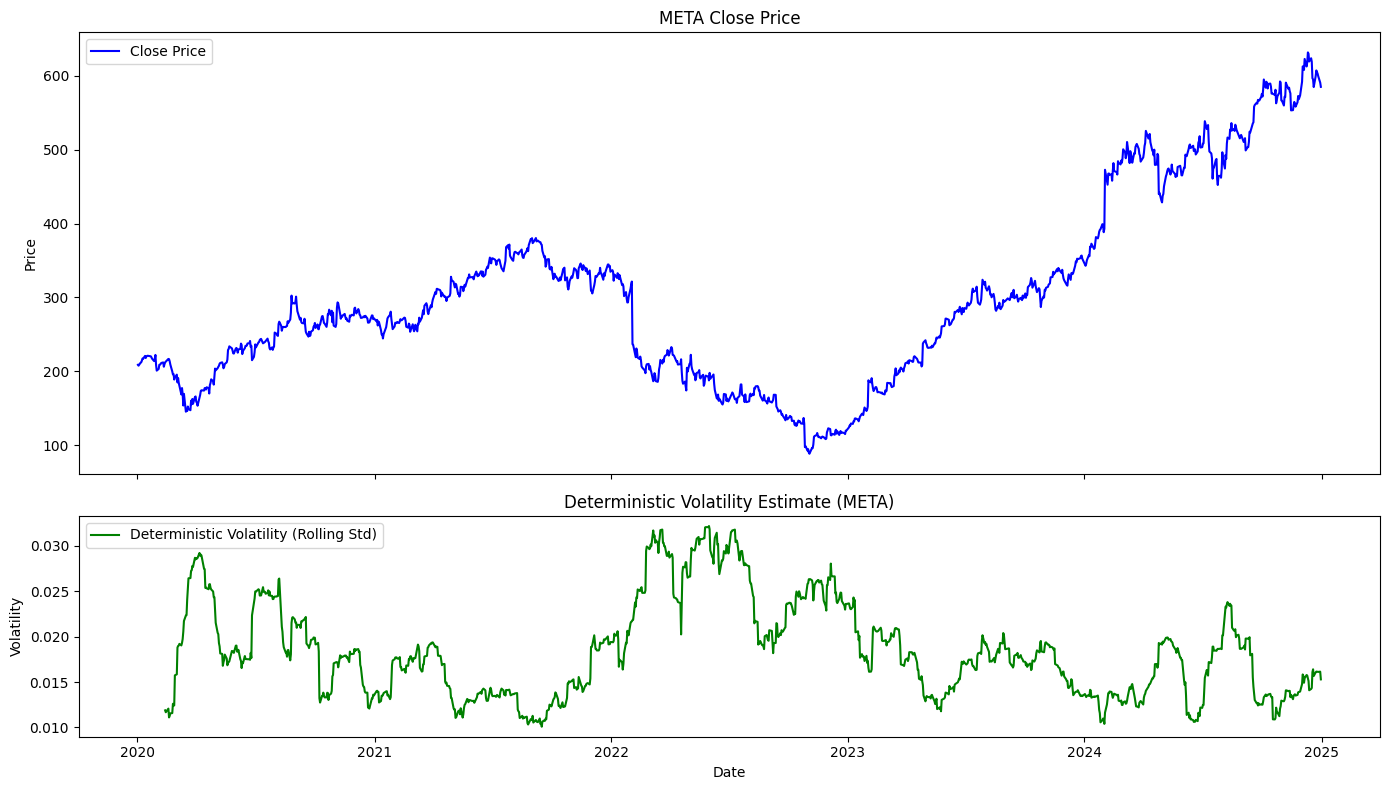

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

def deterministic_volatility(df, window=30):
    """
    Deterministic volatility estimator using rolling standard deviation
    of log returns over a specified window.
    """
    log_returns = np.log(df['Close'] / df['Open'])
    return log_returns.rolling(window=window).std()

# ---------------------------
# Download data
# ---------------------------
symbol = 'META'
start_date = '2020-01-01'
end_date = '2025-01-01'

df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# ---------------------------
# Compute deterministic volatility
# ---------------------------
det_vol = deterministic_volatility(df)

# ---------------------------
# Plotting
# ---------------------------
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# Panel 1: Close Price
ax1.plot(df.index, df['Close'], color='blue', label='Close Price')
ax1.set_ylabel('Price')
ax1.set_title(f'{symbol} Close Price')
ax1.legend(loc='upper left')

# Panel 2: Deterministic Volatility
ax2.plot(det_vol.index, det_vol, color='green', label='Deterministic Volatility (Rolling Std)')
ax2.set_xlabel('Date')
ax2.set_ylabel('Volatility')
ax2.set_title(f'Deterministic Volatility Estimate ({symbol})')
ax2.legend(loc='upper left')

plt.tight_layout()
plt.show()
